0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


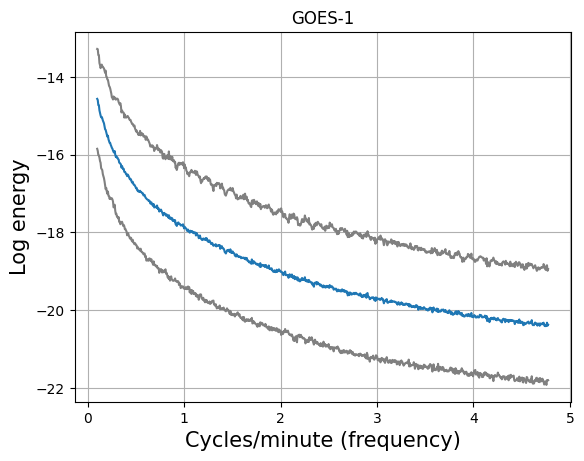

In [1]:
import numpy as np
from read import *
from scipy.signal import lombscargle
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

df = get_goes(2017)

pdf = PdfPages("period_py.pdf")

# Arange the data into blocks containing mp observations, which
# is around mp/30 minutes of data.
mp = 5000
tix, flx = make_blocks(df, mp, 0)

def make_plot(w, ma, ti):
    plt.clf()
    plt.grid(True)
    for m in ma:
        plt.plot(60*w, m)
    plt.ylabel("Energy", size=15)
    plt.xlabel("Cycles/minute (frequency)", size=15)
    plt.title(ti)
    pdf.savefig()
    plt.clf()
    plt.grid(True)
    for m in ma:
        plt.plot(1/(60*w), m)
    plt.ylabel("Energy", size=15)
    plt.xlabel("Minutes/cycle (period)", size=15)
    plt.title(ti)
    pdf.savefig()

# Test data to be sure we are interpreting the plot correctly.  This data
# has a very strong sinusoid with 1 cycle every 10 seconds, or a frequency
# of 0.1 cycles per second, or 6 cycles per minute.
period = 10     # True period
w = 1 / period  # True frequency
ti = np.sort(1000*np.random.uniform(size=100000))
for s in [0.5, 10, 50, 100]:
    flux1 = np.cos(w*2*np.pi*ti) + s*np.random.normal(size=ti.shape[0])
    wf = np.linspace(0.1, 2, 400)  # Frequencies to fit
    m = lombscargle(ti, flux1, wf, precenter=True, normalize=True)
    ww = wf / (2*np.pi)
    make_plot(ww, [m], "Simulated data (s=%.2f)" % s)

ma = []
w = np.linspace(0.01, 0.5, 800)  # Frequencies to fit
ww = w / (2*np.pi)
for k in range(flx.shape[0]):
    if k % 100 == 0:
        print(k)
    m = lombscargle(tix[k, :], np.log(1e-10 + flx[k, :]), w, precenter=True, normalize=True)
    ma.append(m)

ma = np.asarray(ma)

plt.clf()
plt.grid(True)
plt.plot(60*ww, ma.mean(0))
plt.xlabel("Cycles/minute (frequency)", size=15)
plt.ylabel("Energy", size=15)
plt.title("GOES-1")
pdf.savefig()

lma = np.log(ma)
lmn = lma.mean(0)
lma -= lmn
u, s, vt = np.linalg.svd(lma, 0)
v = vt.T

plt.clf()
plt.grid(True)
plt.plot(60*ww, lmn)
f = np.sqrt(s[0])
plt.plot(60*ww, lmn + f*v[:, 0], "-", color="grey")
plt.plot(60*ww, lmn - f*v[:, 0], "-", color="grey")
plt.xlabel("Cycles/minute (frequency)", size=15)
plt.ylabel("Log energy", size=15)
plt.title("GOES-1")
pdf.savefig()

pdf.close()